# Exploratory Data Analysis of the PFT Dataset
This notebook shows some exploratory plots of the PFT dataset to understand the data better.

### Imports

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

### EDA

In [2]:
ds_pft = xr.open_dataset("data/regridded_pft_data/pft-yearly-sliced.nc")

PFT_VARS = [
    "BARE","BUILT",
    "GRASS-MAN","GRASS-NAT",
    "SHRUBS-BD","SHRUBS-BE","SHRUBS-ND","SHRUBS-NE",
    "TREES-BD","TREES-BE","TREES-ND","TREES-NE",
    "WATER_OCEAN","WATER_INLAND","SNOWICE"
]

In [3]:
def plot_regional(
    da,                 # xarray DataArray to plot (dims include latitude, longitude)
    projection=None,    # e.g., ccrs.PlateCarree(), ccrs.LambertConformal(), etc.
    vmin=None, vmax=None, cmap=None, robust=True,
    coast_res='50m', graticules=True, margin_deg=0.5,
    cbar_label=None
):
    """
    Plot a regional map that auto-fits the DataArray's lat/lon extent.
    """
    if projection is None:
        projection = ccrs.PlateCarree()

    # Infer coord names
    lat_name = 'latitude' if 'latitude' in da.coords else 'lat'
    lon_name = 'longitude' if 'longitude' in da.coords else 'lon'

    # Get numeric bounds (handle ascending/descending coords)
    lat_vals = da[lat_name].values
    lon_vals = da[lon_name].values
    lat_min, lat_max = float(lat_vals.min()), float(lat_vals.max())
    lon_min, lon_max = float(lon_vals.min()), float(lon_vals.max())

    # Add a small visual margin
    lat_min_m = lat_min - margin_deg
    lat_max_m = lat_max + margin_deg
    lon_min_m = lon_min - margin_deg
    lon_max_m = lon_max + margin_deg

    # Build figure/axes
    fig = plt.figure(figsize=(7.5, 6))
    ax = plt.axes(projection=projection)

    # IMPORTANT: set extent in the *data CRS* (PlateCarree for lat/lon degrees)
    ax.set_extent([lon_min_m, lon_max_m, lat_min_m, lat_max_m], crs=ccrs.PlateCarree())

    # Nice base layers
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=0)
    ax.coastlines(resolution=coast_res, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    if graticules:
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linewidth=0.4)
        gl.right_labels = False
        gl.top_labels = False

    # Plot (tell Cartopy the data are in PlateCarree/lat-lon)
    im = da.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax, cmap=cmap, robust=robust,
        cbar_kwargs={'label': cbar_label} if cbar_label else {}
    )

    plt.title(da.name if da.name else '')
    return fig, ax, im

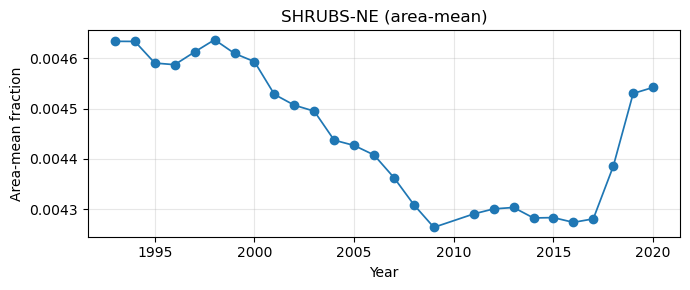

In [56]:
def area_mean_timeseries(ds, var):
    """
    Area-weighted mean over latitude/longitude for each year using cos(lat).
    Returns (years, series) where series has length = number of years.
    """
    da = ds[var]  # dims: year, latitude, longitude

    # 1) latitude weights
    w_lat = np.cos(np.deg2rad(ds['latitude']))        # dims: latitude
    # (optional) normalize so average weight ~ 1
    w_lat = w_lat / w_lat.mean()

    # 2) broadcast to 2D (latitude, longitude) to match da
    w2d = w_lat.broadcast_like(da.isel(year=0))       # dims: latitude, longitude

    # 3) weighted spatial mean per year (NaNs are handled)
    series = da.weighted(w2d).mean(dim=('latitude','longitude'))

    years = ds['year'].values
    return years, series.values

# quick plot
var = 'SHRUBS-NE'
years, series = area_mean_timeseries(ds_pft, var)
plt.figure(figsize=(7,3))
plt.plot(years, series, marker='o', lw=1.25)
plt.ylabel('Area-mean fraction')
plt.xlabel('Year')
plt.title(f'{var} (area-mean)'); plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(f"timeseries_{var}.png", dpi=200)

In [16]:
def plot_pft_map(ds, var, year, projection=None, vmin=0.0, vmax=1.0, cmap='viridis',
                 coast_res='50m', margin=0.5, add_gridlines=True, as_percent=False):
    """
    Plot a single PFT fraction for one year on a regional map.

    Parameters
    ----------
    ds : xr.Dataset
        Your PFT dataset (dims: year, latitude, longitude)
    var : str
        Variable name, e.g. 'TREES-NE'
    year : int
        Year to plot (e.g., 2005)
    projection : cartopy CRS
        Map projection for the GeoAxes. Defaults to PlateCarree()
    vmin, vmax : float
        Color scale limits. Fractions are in [0,1].
    cmap : str or Colormap
        Matplotlib colormap
    as_percent : bool
        If True, multiply by 100 and label as %
    """
    if projection is None:
        projection = ccrs.PlateCarree()

    da = ds[var].sel(year=year)

    # infer bounds and add a small visual margin
    lat = ds['latitude'].values
    lon = ds['longitude'].values
    lat_min, lat_max = float(lat.min()), float(lat.max())
    lon_min, lon_max = float(lon.min()), float(lon.max())
    extent = [lon_min - margin, lon_max + margin, lat_min - margin, lat_max + margin]

    fig = plt.figure(figsize=(7.5, 6))
    ax = plt.axes(projection=projection)

    # set extent in the DATA CRS (PlateCarree for lon/lat degrees)
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # base layers
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=0)
    ax.add_feature(cfeature.OCEAN, facecolor='white', zorder=0)
    ax.coastlines(resolution=coast_res, linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    if add_gridlines:
        gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, linewidth=0.4)
        gl.right_labels = False
        gl.top_labels = False

    # plotting
    to_plot = da * (100.0 if as_percent else 1.0)
    label = f"{var} ({'%' if as_percent else 'fraction'})"

    im = to_plot.plot(
        ax=ax, transform=ccrs.PlateCarree(),
        cmap=cmap, vmin=(vmin*100 if as_percent else vmin), vmax=(vmax*100 if as_percent else vmax),
        cbar_kwargs={'label': label}
    )

    ax.set_title(f"{var} • {year}")
    plt.tight_layout()
    return fig, ax, im

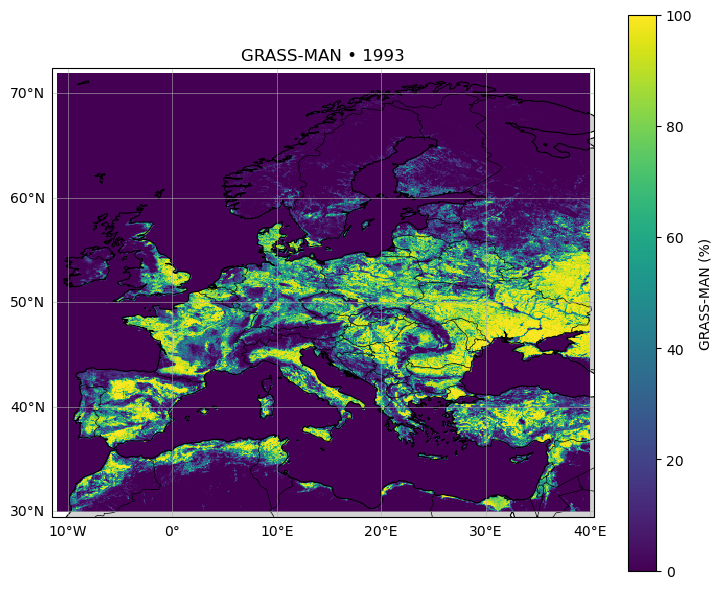

In [23]:
fig, ax, im = plot_pft_map(ds_pft, var='GRASS-MAN', year=1993, as_percent=True)

In [33]:
import math

def plot_pft_panel(ds, vars_to_plot, year, ncols=3, projection=None,
                   vmin=0.0, vmax=1.0, cmap='viridis', as_percent=False):
    """
    Multi-panel map for a selection of PFTs in the same year.
    """
    if projection is None:
        projection = ccrs.PlateCarree()

    # extent from dataset
    lat = ds['latitude'].values
    lon = ds['longitude'].values
    extent = [float(lon.min())-0.5, float(lon.max())+0.5,
              float(lat.min())-0.5, float(lat.max())+0.5]

    n = len(vars_to_plot)
    nrows = math.ceil(n / ncols)

    # set a comfortable figure size
    fig_height = 3.2 * nrows
    fig_width  = 4.2 * ncols
    fig = plt.figure(figsize=(fig_width, fig_height))

    for i, var in enumerate(vars_to_plot, 1):
        ax = plt.subplot(nrows, ncols, i, projection=projection)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.coastlines('50m', linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, linewidth=0.4)
        # optional: light land background
        ax.add_feature(cfeature.LAND, facecolor='whitesmoke', zorder=0)

        da = ds[var].sel(year=year)
        to_plot = da * (100.0 if as_percent else 1.0)

        to_plot.plot(
            ax=ax, transform=ccrs.PlateCarree(),
            cmap=cmap, vmin=(vmin*100 if as_percent else vmin), vmax=(vmax*100 if as_percent else vmax),
            add_colorbar=False # one colorbar per panel is often cluttered
        )
        ax.set_title(var, fontsize=10)

    # optional single shared colorbar:
    # create a hidden axis to draw one colorbar for the last artist
    cbar_label = f"{'%' if as_percent else 'fraction'}"
    cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(vmin=(vmin*100 if as_percent else vmin), vmax=(vmax*100 if as_percent else vmax))
    cb = fig.colorbar(sm, cax=cax, label=cbar_label)
    fig.suptitle(f"Year: {year}", y=0.98, fontsize=12)
    plt.subplots_adjust(right=0.9, hspace=0.25, wspace=0.08)
    return fig


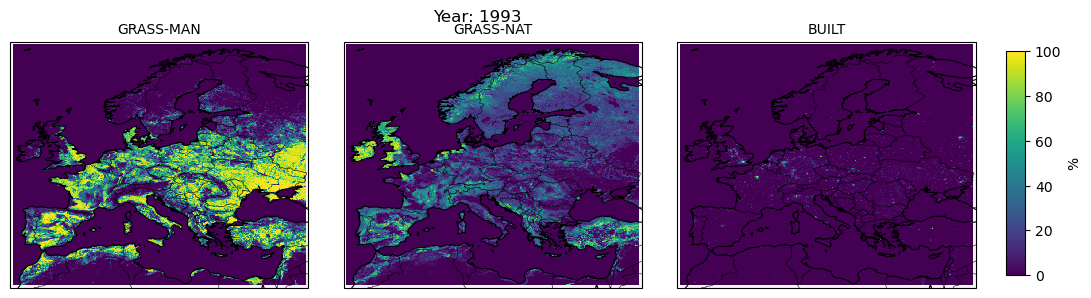

In [45]:
vars_to_plot = ["GRASS-MAN","GRASS-NAT","BUILT"]
fig = plot_pft_panel(ds_pft, vars_to_plot, year=1993, ncols=3, as_percent=True)

fig.savefig("pft_grass_1993.png", dpi=300, bbox_inches='tight')

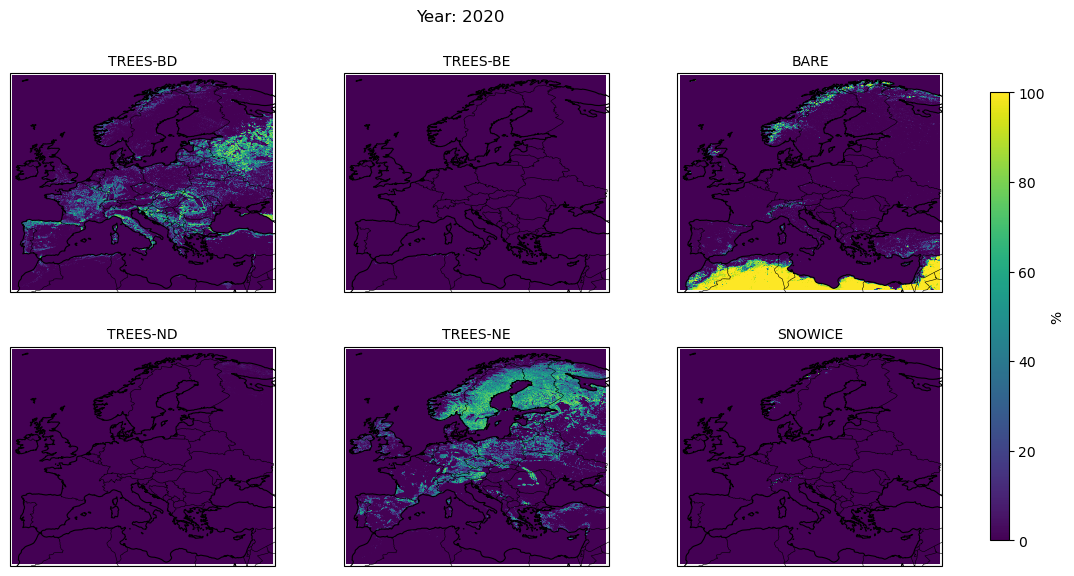

In [36]:
vars_to_plot = ["TREES-BD","TREES-BE","BARE","TREES-ND","TREES-NE","SNOWICE"]
fig = plot_pft_panel(ds_pft, vars_to_plot, year=2020, ncols=3, as_percent=True)

fig.savefig("pft_trees_2020.png", dpi=300, bbox_inches='tight')